In [1]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from abc import abstractmethod
from typing import List, Callable, Union, Any, TypeVar, Tuple
from itertools import cycle
Tensor = TypeVar('torch.tensor')

import os
import math

import numpy as np
import scipy.io as scio
from torch import optim, nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

from torchvision import transforms
import torchvision.utils as vutils


# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

import plotly.express as px
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,  completeness_score, v_measure_score
from scipy.optimize import linear_sum_assignment

import onlineVDP_suff_stat

In [2]:
class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [3]:
class DP_VAE(BaseVAE):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 dpmm_param: dict,
                 hidden_layers: list,
                 output_type: str='linear',
                 **kwargs) -> None:
        
        super(DP_VAE, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dpmm_param = dpmm_param
        self.output_type = output_type
        # the parameters of the DPGMM model
        self.current_result = {}
        self.current_suff_stat = {}
        self.opts = onlineVDP_suff_stat.mkopts_vdp(**dpmm_param)
        print("Log: opts", self.opts)

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers[1], hidden_layers[2]),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(hidden_layers[2], latent_dim)
        self.fc_log_var = nn.Linear(hidden_layers[2], latent_dim)

        # Build Decoder

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_layers[2]),
            nn.ReLU(),
            nn.Linear(hidden_layers[2], hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(hidden_layers[1], hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(hidden_layers[0], self.input_dim)
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network and returns the latent codes.
        param input: (Tensor) Input tensor to encoder [N x C x H x W]
        return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        mu = self.fc_mu(result)
        log_var = self.fc_log_var(result)
        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes onto the image space.
        param z: (Tensor) [B x D]
        return: (Tensor) [B x C x H x W]
        """

        result = self.decoder(z)

        if self.output_type == 'linear':
            pass
        elif self.output_type == 'sigmoid':
            result = torch.sigmoid(result)
        else: # tahn
            result = torch.tanh(result)

        return result
    
    def reparameterize(self, mu: Tensor, log_var: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu  
      
    # Forward propagation: inference network outputs mu(x) and log_var(x) given an input x, then use repameterization trick to sample a batch of z, which are feed to DPGMM model
    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var, z] # [recon, input, mu, log_var, z]

    def reconstruction(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input sample x, returns the reconstructed sample
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

    def fit_dpmm(self, z):
        # use the lanter variables z of the entire dataset to fit the DPGMM model
        # for the DPGMM, the dimension of input is D*N, while for the VAE, the dimension of input is N*D
        z = z.detach().cpu().t()
        init_prior = onlineVDP_suff_stat.mk_hp_prior(z, **self.dpmm_param)
        current_result = onlineVDP_suff_stat.online_vdpgmm_suffstat(z, init_prior, self.opts, move_dict_to_device(self.current_result, z.device))
        self.current_result = current_result
        self.current_suff_stat = current_result['sum_stat']
        current_K = self.current_result['K']

        self.calc_cluster_component_params()
        
    def calc_cluster_component_params(self):
        # expected value of mean vector and covariance matrix of each gaussian component in the DPGMM

        # means and covariance matrices
        self.comp_mu = [self.current_result['hp_posterior']['m'][:,k] for k in range(self.current_result['K']-1)]
        self.comp_var = [torch.inverse(self.current_result['hp_posterior']['lambda'][:,k]*self.current_result['hp_posterior']['W'][:,:,k]) for k in range(self.current_result['K']-1)]
        print("Log: current K", self.current_result['true_K']) # ignore the additional component
        
    # we use the entire set of lantent variables z to fit the DPGMM model, but when calculating the loss, we only use a batch of data
    # the cluster_assignments function outputs the responsibility and the hard assignments of the data in the batch

    # Backprop: calculate the loss function
    # loss = reconstruction loss + KL divergence   
    def loss_function(self,
                    *args,
                    batch_size,
                    batch_idx,
                    kl_weight) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2] # u(z|x)
        log_var = args[3] # sigma(z|x)
        z = args[4]  # batch_size * latent_dim

        # reconstruction loss
        recons_loss = F.mse_loss(recons, input, reduction='sum')

        # calculate kl divergence
        kld_weight = kl_weight # Account for the minibatch samples from the dataset
        # kl_weight = batch_size/size of the entire training set,

        #estimate the DPGMM
        if len(self.current_result) == 0:

            kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            loss = recons_loss + kld_weight * kld_loss
            return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z}
        
        else:
            #prob_comps --> responsibilities, comps --> Z[n] cluster assignments 
            #soft assignment and hard assignment
            prob_comps, comps = self.cluster_assignments(z.detach().cpu()) # soft assignment N*K real_K = q_of_z.shape[1]-1
            #print(f"num_q_of_z:{self.current_posterior['q_of_z'].shape[1]}")
            #_ , comps = torch.max(prob_comps, dim=1) # comps: hard assignment, size = K

            # get a distribution of the latent variables
            var = torch.exp(0.5 * log_var)**2
            # batch_shape [batch_size], event_shape [latent_dim]
            dist = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(var))  # distribution of z obtained from the encoder

            # get a distribution for each cluster
            B, K = prob_comps.shape # batch_shape (number of samples in the current minibatch), number of active clusters
            #print("Log: B, K", B, K)
            #print("Log: prob_comps", prob_comps.shape)
            kld = torch.zeros(B).to(mu.device)

            for k in range(K):
            # batch_shape [], event_shape [latent_dim]

            # responsibility to the kth component
                prob_k = prob_comps[:, k] # size = B, responsibility of the kth component
                dist_k = torch.distributions.MultivariateNormal(loc=self.comp_mu[k].to(mu.device), covariance_matrix=torch.diag_embed(torch.diag(self.comp_var[k]).to(mu.device))) # use diagonal covariance matrix here

            # batch_shape [batch_size], event_shape [latent_dim]

            # mini_batch 中每个zi都服从一个对应的multivariate normal分布zi - N(u(zi|xi),sigma(zi|xi))), 所以一共batch_size个multivariate normal分布
            # 它们分别与第k个component，即N(uk,sigmak)求KL-divergence，再取平均，得到batch的 KL loss

                expanded_dist_k = dist_k.expand(dist.batch_shape) # 把第k个component复制batch_shape次，再以tensor的形式一起计算KL divergence

                kld_k = torch.distributions.kl_divergence(dist, expanded_dist_k)   #  shape [batch_shape, ]

                #print(f"prob_k_shape:{prob_k.shape}, kld_k_shape:{kld_k.shape}")

                kld += prob_k.to(mu.device) * kld_k

        # 最终的 KL loss是minibatch中每个sample的KL loss的平均
        kld_loss = torch.mean(kld)

        loss = recons_loss + kld_weight * kld_loss
        loss = loss.to(input.device)
        return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z, 'comps': comps}

    def cluster_assignments(self, z):
        # z: batch_size * latent_dim --> z.t(): latent_dim * batch_size
        q_of_z, _, _ = onlineVDP_suff_stat.mk_q_of_z(z.t(), self.current_result['hp_posterior'], self.current_result['hp_prior'], self.opts)
        # Here, responsibility is a 2D array of size N x K. here N is batch size, K active clusters
        # Each entry resp[n, k] gives the probability that data atom n is assigned to cluster k under the posterior.
        resp = q_of_z[:,:-1]
        # To convert to hard assignments
        Z = resp.argmax(axis=1)
        return resp, Z

In [4]:
def move_dict_to_device(state_dict, device):
    '''move all tensors in state_dict to the device'''
    new_state_dict = {}
    for k, v in state_dict.items():
        if isinstance(v, torch.Tensor):
            new_state_dict[k] = v.to(device)
        else:
            new_state_dict[k] = v
    return new_state_dict

def forward(model, input: Tensor, **kwargs) -> Tensor:
    return model(input, **kwargs)
    
    
def training_step(model, batch_samples, batch_labels, batch_idx, kl_weight):
    curr_device = batch_samples.device

    batch_size = batch_samples.size(0)
    results = forward(model, batch_samples, labels = batch_labels)
    train_loss = model.loss_function(*results, batch_size = batch_size, batch_idx = batch_idx,
                                              kl_weight = kl_weight,
                                              )
    #for name, metric in train_loss.items():
        #if "loss" in name:
            #log("train_" + name, metric.mean().item(), on_step=False, on_epoch=True, prog_bar=True)

    train_loss.update({'labels': batch_labels})
    #print(f"train_loss:{train_loss}")
    return train_loss    # latent encoding

def training_epoch_end(model, current_epoch, total_epochs, dpmm_init_epoch, outputs):
    if current_epoch >= dpmm_init_epoch:
        z = torch.cat([outputs[i]['z'] for i in range(0, len(outputs))])
        model.fit_dpmm(z)
    
    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        #comps = np.array([outputs[i]['comps'] for i in range(0, len(outputs))]).flatten()
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        #print(f"labels:{labels}")
        #print(f"comps:{comps}")
        acc, _ = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)
        #self.log("train_clustering_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        #self.log("Number_of_DP_Comps", int(self.model.bnp_model.obsModel.K), on_step=False, on_epoch=True, prog_bar=True)
        print(f"train_clustering_acc:{acc}", f"train_ars:{ars}", f"train_nmi:{nmi}")
        print(f"Number_of_DP_Comps:{model.current_result['true_K']}")
        Nk = model.current_result['sum_stat']['Nk'].flatten()
        formatted_Nk = ', '.join(map(lambda x: f"{x:.2f}", Nk.numpy()))
        print(f"Nk = [{formatted_Nk}]")

        return comps, labels, acc
    
def validation_step(model, batch_samples, batch_labels, batch_idx, kl_weight):
    batch_size = batch_samples.size(0)
    results = forward(model, batch_samples, labels = batch_labels)
    val_loss = model.loss_function(*results, batch_size = batch_size, batch_idx = batch_idx, kl_weight = kl_weight)
                                        
    val_loss.update({'labels': batch_labels})
    
    return val_loss

def validation_epoch_end(current_epoch, total_epochs, outputs):
    
    print(f"====================== Validation Epoch: {current_epoch} ========================")

    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        acc, _ = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        print(f"valid_clustering_acc:{acc}", f"valid_ars:{ars}", f"valid_nmi:{nmi}")
        return acc
        
def test_epoch(current_epoch, total_epochs, outputs):

    if "comps" in outputs[0]:
        comps = []
        for i in range(0, len(outputs)):
            comps.extend(outputs[i]['comps'])
        comps = np.array(comps)
        labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
        acc, _ = unsupervised_clustering_accuracy(labels.numpy(), comps)
        ars = adjusted_rand_score(labels.numpy(), comps)
        nmi = normalized_mutual_info_score(labels.numpy(), comps)

        print(f"test_clustering_acc:{acc}", f"test_ars:{ars}", f"test_nmi:{nmi}")

        return acc
        

def unsupervised_clustering_accuracy(y: Union[np.ndarray, torch.Tensor], y_pred: Union[np.ndarray, torch.Tensor]) -> tuple:
        """Unsupervised Clustering Accuracy
        """
        assert len(y_pred) == len(y)
        u = np.unique(y)
        n_true_clusters = len(u)
        v = np.unique(y_pred)
        n_pred_clusters = len(v)
        map_u = dict(zip(u, range(n_true_clusters)))
        map_v = dict(zip(v, range(n_pred_clusters)))
        inv_map_u = {v: k for k, v in map_u.items()}
        inv_map_v = {v: k for k, v in map_v.items()}
        r = np.zeros((n_pred_clusters, n_true_clusters), dtype=np.int64)
        for y_pred_, y_ in zip(y_pred, y):
            if y_ in map_u:
                r[map_v[y_pred_], map_u[y_]] += 1
        reward_matrix  = np.concatenate((r, r, r), axis=1)
        cost_matrix = reward_matrix.max() - reward_matrix
        row_assign, col_assign = linear_sum_assignment(cost_matrix)

        # Construct optimal assignments matrix
        row_assign = row_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        col_assign = col_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        assignments = np.concatenate((row_assign, col_assign), axis=1)
        assignments = [[inv_map_v[x], inv_map_u[y%n_true_clusters]] for x, y in assignments]

        optimal_reward = reward_matrix[row_assign, col_assign].sum() * 1.0
        return optimal_reward / y_pred.size, assignments       

In [5]:
def damage_detection_acc(y, y_pred):
    y = y.astype(int)
    y_pred = y_pred.astype(int)
    
    fn = 0
    fp = 0
    most_tru = np.bincount(y).argmax()
    #most_pre = 3
    most_pre = np.bincount(y_pred).argmax()


    for i in range(len(y)):
        if y[i] == most_tru and y_pred[i] != most_pre:
            fp += 1
        if y[i] != most_tru and y_pred[i] == most_pre:
            fn += 1
        dda = 1 - (fn + fp) / len(y)        
    return dda, fn, fp

In [6]:
batch_size = 32
seeds = [12345,1234,600,100,10,12345*2,400,20000]
torch.manual_seed(12345)
# initial_state = torch.get_rng_state()
# initial_cuda_state = torch.cuda.get_rng_state()
performance_seed = []
total_epochs = 150


for seed in seeds:
    
    print(f"====================== Seed: {seed} ========================")
    
    #torch.set_rng_state(initial_state)

    #torch.cuda.set_rng_state(initial_cuda_state)

    torch.manual_seed(seed)  # ensure reproducible results

    # # # Read data from CSV
    # features = pd.read_csv("TF_numerical1.csv")
    # features = features.astype("float32")
    # # Convert DataFrame to PyTorch tensors
    # X = torch.tensor(features.values[:600,:])
    # X = X.transpose(0,1)

    '''use a numerical dataset to test the model
    label  damaged_floor     damage_extent         number_of_samples
    0           0            0%                     600
    1           1            5%                     200
    2           1            10%                    200
    3           2,4          10%, 10%               200
    4           1,3,5        10%,15%,20%            200
    5           2,4,6        15%,20%,25%            200
    6           1,3,5,7      10%,15%,20%,25%        200
    7           1,2,4,6,8    10%,15%,20%,25%,30%    200

    '''
   # Read data from CSV
    features = pd.read_csv("toy_dataset.csv")
    features = features.astype("float32")
    # # # Convert DataFrame to PyTorch tensors
    X = torch.tensor(features.values[:,:1000])

    input_dim = X.shape[1]
    print(X.shape)

    y0 = torch.tensor(features.values[:,1000])
    y0 = y0.unsqueeze(1)
    y = [int(_) for _ in y0] #+ 0.01*y0.mean()*torch.randn(y0.shape[0], 1)
    y = torch.tensor(y)
    # Split the data into training and test sets

    dataset = TensorDataset(X, y)

    train_size = int(0.8 * len(dataset))
    test_size = int(0.1 * len(dataset))
    valid_size = len(dataset) - train_size - test_size
    train_dataset, test_dataset, valid_dataset = random_split(dataset, [train_size, test_size, valid_size])

    # Accessing the tensors from train_dataset and test_dataset
    x_train, y_train = train_dataset[:]
    x_valid, y_valid = valid_dataset[:]
    # Optionally, you can also access the test set
    x_test, y_test = test_dataset[:]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)

    dp_alpha = 10.0
    latent_dim = 10
    model_params = dict(
        input_dim = input_dim,
        latent_dim = latent_dim,
        hidden_layers = [500, 500, 2000],
        dpmm_param = dict(
            alpha=torch.tensor(dp_alpha),
            beta0=torch.tensor(0.01),
            max_iter_merge = 10,
            max_iter_split = 3,
            max_merge = 10,
            max_split = 5,
            ite = 100,
        )
    )
    # MLP format
    model = DP_VAE(**model_params).to(device)
    print(model.state_dict)
        # plt.plot(y)
    # plt.show()

    # training phase
    optimizer = optim.Adam(model.parameters(), lr = 5e-5, weight_decay = 0)
    kl_weight = 1 #batch_size/len(train_loader.dataset)
    # total_epoch拟合DPGMM-训练vae 这一循环的epoch
    dpmm_init_epoch = 0

    training_loss_epoch = []
    recon_loss_epoch = []
    kl_loss_epoch = []

    val_loss_epoch = []
    val_recon_loss_epoch = []
    val_kl_loss_epoch = []

    training_acc_epoch = []
    val_acc_epoch = []
    test_acc_epoch = []

    y_ground_truth = torch.tensor([])

    for epoch in range(total_epochs):

        pbar = tqdm(train_loader, desc=f"current_epoch {epoch}/{total_epochs}")
            # training_loss_batch只记录training loss (total loss)
        training_loss_batch = []
        recon_loss_batch = []
        kl_loss_batch = []
            # train_loss_batch = [] 将一个epoch中所有mini_batch数据训练得出的loss存入一个列表, 包括 total loss， reconstruction loss， kl loss,‘z’,'components'
        train_loss_batch = []
        batch_idx = 0
        for batch_samples, batch_labels in pbar:

            if epoch == total_epochs - 1:
                y_ground_truth = torch.cat([y_ground_truth, batch_labels])

            batch_samples = batch_samples.to(device)

            #train_loss = model.loss_function(*results, # M_N = self.params['batch_size']/ self.num_train_imgs,
                                                    #M_N=1/train_size, optimizer_idx = 0, batch_idx = batch_idx, device = 'cpu')

            train_loss = training_step(model, batch_samples, batch_labels, batch_idx, kl_weight)
            train_loss_batch.append(train_loss)
            

            # total loss in of a minibatch
            training_loss = train_loss['loss']
            training_loss_batch.append(train_loss['loss'].item())
            recon_loss_batch.append(train_loss['reconstruction_loss'].item())
            kl_loss_batch.append(kl_weight*train_loss['kld_loss'].item())


            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()

            batch_idx += 1


        training_loss_epoch.append(np.mean(training_loss_batch))
        recon_loss_epoch.append(np.mean(recon_loss_batch))
        kl_loss_epoch.append(np.mean(kl_loss_batch))

        print(f"training_loss:{np.mean(training_loss_batch):.4f}", f"reconstruction_loss:{np.mean(recon_loss_batch):.4f}", f"kl_loss:{np.mean(kl_loss_batch):.4f}")

        if "comps" in train_loss_batch[0]:
            with torch.no_grad():
                test_loss_batch = []
                batch_idx_test = 0
                
                for batch_samples, batch_labels in test_loader:
                    batch_samples = batch_samples.to(device)
                    test_loss = validation_step(model, batch_samples, batch_labels, batch_idx_test, kl_weight = 1)# batch_size/len(valid_loader.dataset))
                    test_loss_batch.append(test_loss)
                    batch_idx_test += 1

                test_acc = test_epoch(epoch, total_epochs, test_loss_batch)
                test_acc_epoch.append(test_acc)

        if "comps" in train_loss_batch[0]:
            comps0, labels0, training_acc = training_epoch_end(model, epoch, total_epochs, dpmm_init_epoch, train_loss_batch)
            training_acc_epoch.append(training_acc)
        else:
            training_epoch_end(model, epoch, total_epochs, dpmm_init_epoch, train_loss_batch)

        #if epoch > 0:
        with torch.no_grad():

            val_loss_batch = []
            valid_loss_batch = []
            val_recon_loss_batch = []
            val_kl_loss_batch = []
            batch_idx_val = 0

            for batch_samples, batch_labels in valid_loader:

                batch_samples = batch_samples.to(device)
                val_loss = validation_step(model, batch_samples, batch_labels, batch_idx_val, kl_weight = 1) # batch_size/len(valid_loader.dataset))
                val_loss_batch.append(val_loss)

                valid_loss_batch.append(val_loss['loss'].item())
                val_recon_loss_batch.append(val_loss['reconstruction_loss'].item())
                val_kl_loss_batch.append(kl_weight*val_loss['kld_loss'].item())

                batch_idx_val += 1
            
            val_loss_epoch.append(np.mean(valid_loss_batch))
            val_recon_loss_epoch.append(np.mean(val_recon_loss_batch))
            val_kl_loss_epoch.append(np.mean(val_kl_loss_batch))
            
            val_acc = validation_epoch_end(epoch, total_epochs, val_loss_batch)
            val_acc_epoch.append(val_acc)
            print(f"valid_loss:{np.mean(valid_loss_batch):.4f}", f"val_reconstruction_loss:{np.mean(val_recon_loss_batch):.4f}", f"val_kl_loss:{np.mean(val_kl_loss_batch):.4f}")


    # performance on the training set
    np.random.seed(seed)
    latent_variables = torch.tensor([])
    for i in range(len(train_loss_batch)): 
        latent_variables = torch.cat([latent_variables,train_loss_batch[i]['z'].cpu()],dim=0)
        
    print(latent_variables.shape)

    preds = model.current_result['hard_assign']

    #  clustering accuracy of the training set
    acc_training, _ = unsupervised_clustering_accuracy(y_ground_truth.numpy().astype(int), preds.numpy())
    ars_training = adjusted_rand_score(y_ground_truth.numpy().astype(int), preds.numpy())
    nmi_training = normalized_mutual_info_score(y_ground_truth.numpy().astype(int), preds.numpy())


    # validation set performance
    y_valid = torch.tensor([])
    for batch_samples, batch_labels in valid_loader:
        y_valid = torch.cat([y_valid, batch_labels], dim=0)

    latent_val = torch.tensor([])
    preds_val = torch.tensor([])
    for i in range(len(val_loss_batch)): 
        latent_val = torch.cat([latent_val,val_loss_batch[i]['z'].cpu()],dim=0)
        preds_val = torch.cat([preds_val,val_loss_batch[i]['comps'].cpu()],dim=0)

    acc_valid, _ = unsupervised_clustering_accuracy(y_valid.numpy().astype(int), preds_val.numpy())
    ars_valid = adjusted_rand_score(y_valid.numpy().astype(int), preds_val.numpy())
    nmi_valid = normalized_mutual_info_score(y_valid.numpy().astype(int), preds_val.numpy())    

    # test set performance
    y_test = torch.tensor([])
    for batch_samples, batch_labels in test_loader:
        y_test = torch.cat([y_test, batch_labels], dim=0)

    latent_test = torch.tensor([])
    preds_test = torch.tensor([])
    for i in range(len(test_loss_batch)): 
        latent_test = torch.cat([latent_test,test_loss_batch[i]['z'].cpu()],dim=0)
        preds_test = torch.cat([preds_test,test_loss_batch[i]['comps'].cpu()],dim=0)


    acc_test, assignment_test = unsupervised_clustering_accuracy(y_test.numpy().astype(int), preds_test.numpy())
    ars_test = adjusted_rand_score(y_test.numpy().astype(int), preds_test.numpy())
    nmi_test = normalized_mutual_info_score(y_test.numpy().astype(int), preds_test.numpy())
    dda_test = damage_detection_acc(y_test.numpy().astype(int), preds_test.numpy())
    print(acc_test, ars_test, nmi_test, dda_test)


    # performance on the test set after mapping
    mapping = {}
    try:
        for i,j in assignment_test:
            mapping[i] = j
        test_mapped_labels = [mapping[i] for i in preds_test.numpy()]
    except:
        test_mapped_labels = y_test.numpy().astype(int)

    #acc_test, _ = unsupervised_clustering_accuracy(test_mapped_labels, preds_test.numpy())
    ars_test_mapped = adjusted_rand_score(test_mapped_labels, preds_test.numpy())
    nmi_test_mapped = normalized_mutual_info_score(test_mapped_labels, preds_test.numpy())
    dda_test_mapped = damage_detection_acc(np.array(test_mapped_labels), preds_test.numpy())
    print(acc_test, ars_test, nmi_test, dda_test_mapped)


    metrics = dict(
    test_unsupervised_accuracy = acc_test,
    damage_detection_accuracy = dda_test[0],
    false_negative = dda_test[1],
    false_positive = dda_test[2],
    nmi=normalized_mutual_info_score(preds_test.numpy(), y_test.numpy().astype(int)),
    homogeneity_score=homogeneity_score(preds_test.numpy(), y_test.numpy().astype(int)),
    completeness_score=completeness_score(preds_test.numpy(), y_test.numpy().astype(int)),
    v_measure_score=v_measure_score(preds_test.numpy(), y_test.numpy().astype(int)),
    adjusted_rand_score=adjusted_rand_score(preds_test.numpy(), y_test.numpy().astype(int)),
    )

    metrics_mapped = dict(
    test_unsupervised_accuracy = acc_test,
    damage_detection_accuracy = dda_test_mapped[0],
    false_negative = dda_test_mapped[1],
    false_positive = dda_test_mapped[2],
    nmi=normalized_mutual_info_score(preds_test.numpy(), test_mapped_labels),
    homogeneity_score=homogeneity_score(preds_test.numpy(), test_mapped_labels ),
    completeness_score=completeness_score(preds_test.numpy(), test_mapped_labels ),
    v_measure_score=v_measure_score(preds_test.numpy(), test_mapped_labels ),
    adjusted_rand_score=adjusted_rand_score(preds_test.numpy(), test_mapped_labels ),
    embeddings = latent_test,
    test_preds=preds_test.numpy(),
    test_labels=y_test.numpy().astype(int),
    test_mapped_labels=test_mapped_labels
    )

    performance_ = dict(seed = seed, metrics = metrics, mapped_metrics = metrics_mapped)
    performance_seed.append(performance_)

====================== Seed: 12345 ========================
torch.Size([2000, 1000])
cuda
Log: opts {'algorithm': 'vdp', 'init_of_split': 'pc', 'initial_K': 1, 'do_sort': 1, 'do_greedy_split': 1, 'do_split': 0, 'do_merge': 1, 'get_q_of_z': 0, 'get_E_pi': 0, 'get_log_likelihood': 0, 'max_iter_merge': 10, 'max_iter_split': 3, 'max_merge': 10, 'max_split': 5, 'ite': 100, 'threshold': 1e-05, 'min_split_size': 2, 'alpha': tensor(100.), 'beta0': tensor(0.0100)}
<bound method Module.state_dict of DP_VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=2000, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=2000, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=2000, bias=True)
    (1): ReL

current_epoch 0/150: 100%|██████████| 50/50 [00:00<00:00, 132.19it/s]


training_loss:2685.1493 reconstruction_loss:2684.9217 kl_loss:0.2277
### greedy splitting ###
free_energy not decreased after splitting
F=18913;    Nk=[1600.00, 0.00];
merge step is not implemented
Log: current K 1
====================== Validation Epoch: 0 ========================
valid_clustering_acc:0.36 valid_ars:0.0 valid_nmi:0.0
valid_loss:1304.0091 val_reconstruction_loss:1303.8858 val_kl_loss:0.1233


current_epoch 1/150: 100%|██████████| 50/50 [00:00<00:00, 107.24it/s]


training_loss:1325.8505 reconstruction_loss:1324.9156 kl_loss:0.9348
test_clustering_acc:0.3 test_ars:0.0 test_nmi:0.0
### greedy splitting ###
free_energy not decreased after splitting
F=20255;    Nk=[1572.58, 27.42, 0.00];
### merge step ###
less than 2 components
Log: current K 1
train_clustering_acc:0.2925 train_ars:0.0 train_nmi:0.0
Number_of_DP_Comps:1
Nk = [1600.00, 0.00]
====================== Validation Epoch: 1 ========================
valid_clustering_acc:0.36 valid_ars:0.0 valid_nmi:0.0
valid_loss:1003.1912 val_reconstruction_loss:1001.8922 val_kl_loss:1.2990


current_epoch 2/150: 100%|██████████| 50/50 [00:00<00:00, 101.78it/s]


training_loss:1084.0857 reconstruction_loss:1079.1897 kl_loss:4.8960
test_clustering_acc:0.3 test_ars:0.0 test_nmi:0.0
### greedy splitting ###
free_energy not decreased after splitting
F=18647;    Nk=[1105.50, 494.50, 0.00];
### merge step ###
free_energy not decreased after merging
F=18647;    Nk=[1105.50, 494.50, 0.00];
Log: current K 2
train_clustering_acc:0.2925 train_ars:0.0 train_nmi:0.0
Number_of_DP_Comps:2
Nk = [1105.50, 494.50, 0.00]
====================== Validation Epoch: 2 ========================
valid_clustering_acc:0.45 valid_ars:0.22881493123094065 valid_nmi:0.4480228631896178
valid_loss:740.9144 val_reconstruction_loss:738.4902 val_kl_loss:2.4243


current_epoch 3/150: 100%|██████████| 50/50 [00:00<00:00, 60.54it/s]


training_loss:733.5058 reconstruction_loss:728.2951 kl_loss:5.2107
test_clustering_acc:0.44 test_ars:0.2784653297069816 test_nmi:0.49928706049361626
### greedy splitting ###
free_energy not decreased after splitting
F=12929;    Nk=[671.53, 312.86, 283.18, 168.10, 164.32, 0.00];
### merge step ###
free_energy not decreased after merging
F=12929;    Nk=[671.53, 312.86, 283.18, 168.10, 164.32, 0.00];
Log: current K 5
train_clustering_acc:0.396875 train_ars:0.23792090683998424 train_nmi:0.45902908857839214
Number_of_DP_Comps:5
Nk = [671.53, 312.86, 283.18, 168.10, 164.32, 0.00]
====================== Validation Epoch: 3 ========================
valid_clustering_acc:0.625 valid_ars:0.38198725362096764 valid_nmi:0.6644173669500891
valid_loss:536.1637 val_reconstruction_loss:532.9006 val_kl_loss:3.2631


current_epoch 4/150: 100%|██████████| 50/50 [00:01<00:00, 42.19it/s]


training_loss:593.7103 reconstruction_loss:588.2197 kl_loss:5.4906
test_clustering_acc:0.605 test_ars:0.430445573481514 test_nmi:0.6963981561543838
### greedy splitting ###
free_energy not decreased after splitting
F=3703.8;    Nk=[632.81, 315.00, 314.29, 167.00, 166.00, 4.90, 0.00];
### merge step ###


KeyboardInterrupt: 

0.9713897688624954
0.9725705164869517
0.99


c:\Users\MLF\anaconda3\envs\DP_VAE\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\MLF\anaconda3\envs\DP_VAE\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Text(0.5, 1.0, 't-SNE Visualization of the latent space')

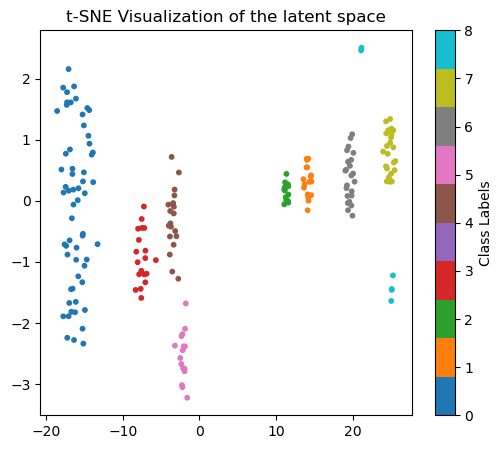

In [7]:
a = performance_seed[0]['mapped_metrics']
print(adjusted_rand_score(a['test_preds'], a['test_labels']))
print(adjusted_rand_score(a['test_preds'], a['test_mapped_labels']))

test_acc,_ = unsupervised_clustering_accuracy(a['test_labels'], a['test_preds'])

print(test_acc)
embeddings = a['embeddings'].detach().numpy()
tsne = TSNE(n_components=2, random_state=12345)
embeddings_2d = tsne.fit_transform(embeddings)
plt.figure(figsize=(6, 5))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=a['test_preds'], cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(15), label='Class Labels')
plt.title('t-SNE Visualization of the latent space')

In [8]:
for i in range(len(performance_seed)):
    print(f"alpha = {dp_alpha}")
    print(f"seed:{performance_seed[i]['seed']}")
    print(f"metrics:{performance_seed[i]['metrics']}")

alpha = 100.0
seed:12345
metrics:{'test_unsupervised_accuracy': 0.99, 'damage_detection_accuracy': 1.0, 'false_negative': 0, 'false_positive': 0, 'nmi': 0.9720453552573621, 'homogeneity_score': 0.9545133949573635, 'completeness_score': 0.9902334003432308, 'v_measure_score': 0.9720453552573621, 'adjusted_rand_score': 0.9713897688624954}
alpha = 100.0
seed:1234
metrics:{'test_unsupervised_accuracy': 1.0, 'damage_detection_accuracy': 0.995, 'false_negative': 0, 'false_positive': 1, 'nmi': 0.9859729110058458, 'homogeneity_score': 0.9723338969019689, 'completeness_score': 1.0, 'v_measure_score': 0.9859729110058456, 'adjusted_rand_score': 0.9829126263611379}
alpha = 100.0
seed:600
metrics:{'test_unsupervised_accuracy': 1.0, 'damage_detection_accuracy': 1.0, 'false_negative': 0, 'false_positive': 0, 'nmi': 0.9950108122302619, 'homogeneity_score': 0.9900711613011278, 'completeness_score': 1.0, 'v_measure_score': 0.9950108122302618, 'adjusted_rand_score': 0.9962676274398423}
alpha = 100.0
seed:

In [9]:
# Define the file name
output_file = 'output_alpha100_dda.txt'

# Open the file in write mode
with open(output_file, 'w') as f:
    for i in range(len(performance_seed)):
        test_preds = performance_seed[i]['mapped_metrics']['test_preds']
        unique_values = np.unique(test_preds)
        K = len(unique_values)
        f.write(f"alpha: {dp_alpha}\n")
        f.write(f"num_clusters: {K}\n")
        f.write(f"seed: {performance_seed[i]['seed']}\n")
        f.write(f"metrics: {performance_seed[i]['metrics']}\n")
        a = list(performance_seed[i]['mapped_metrics'].items())[:len(performance_seed[i]['metrics'])]
        f.write(f"mapped_metrics: {a}\n")
        f.write("\n")  # Add a newline for better readability